In [25]:
# Last time we looked at building a multi-layer perceptron (MLP) following bengio et al to create a name generator. This time, we are going to move forward in history to the next significant step
# by using Recurrent Neural Networks (RNN) and Gated Recursive Convolutional Neural Networks (GRU).
# To really understand these new models, we are going to first dive deeper into MLPs to understand their gradients and back-propagations. This will help us understand why the new approaches
# are hard to optimize, and what we can do about it.

# The first 10 or so code entries in this notebook are clean-up versions of the old MLP code we wrote in the last study.

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [26]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [27]:
len(words)

32033

In [28]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [29]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80% training split
Xdev, Ydev = build_dataset(words[n1:n2])   # 10% dev split
Xte,  Yte  = build_dataset(words[n2:])     # 10% test split

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [61]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # The multiplications are meant to initialize correctly by scaling the std dev
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 #trying to get an even distribution, but letting in a little entropy
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 #Don't make this 0, but make it small. Gives us a more even distribution to get rid of the hockey stick effect
b2 = torch.randn(vocab_size,                      generator=g) * 0 #The first loss from the feed forward is way too high. We need a more even distribution at the start. Don't add bias

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# It turns out that due to new inventions, we aren't really affected by poor initializations. One of those inventions is batch normalizations. We will get to this later.
# Ok now is later =) Batch normalization exists to solve the problem outlined in the matplotlib image a few lines below. Neurons that are on the tail end of the tanh function won't learn.
# Optimally, we want a gaussian distribution with a mean of 0 and a std dev of 1. The idea of batch normalization is that you can just initialize your set to be gaussian =) Of course,
# during training, we don't want to hold this distribution, but rather let the backpropagation tell us what is best. To allow this, we create to new parameters bngain and bnbias, and call
# backwards after every feed forward.

# The weird part about this is that we used to deterministically optimize an input value by feeding forward and passing back. For efficiency, we split the gradient descent into batches,
# with the idea being we can approximate the gradient over a subset of the neurons to a good enough degree. Now all of the sudden, the optimization is a function of the input, but also
# the other neurons that happen to come for a ride in the batch =) Better yet, the batches are randomized =) This means your hidden layer values (and logits) will have some 'jiggle' 
# in them, because the mean and std dev statistics will change depending on what is in the batch. As it turns out, this is a good thing. Think of it as a regularizer. It dampens the
# examples. The jiggle makes it hard for the model to overfit the data because of the noise.

# No one really likes the fact that these variables are coupled to the forward pass. There are a few alternatives that we will explore later.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [62]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # This is batch normalization

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001  * bnstdi

  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  #break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


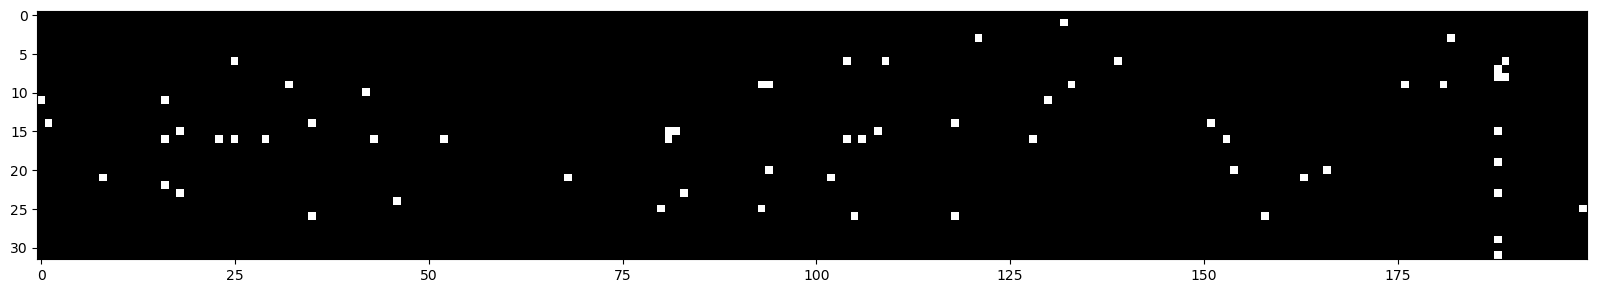

In [53]:
# Something that really hinders our neurons ability to learn is bad initializations. Our activation function is tanh, which has 2 tails at either end. If most of our neuron values are on 
# the tails, the backprop tends to either 0 or 1, since the local gradient is 1-t**2. This means the gradient either goes to 0, or just pushes through without much change (1). Both of these 
# hinder our ability to learn since our gradients only change a small little bit, so we don't make any progress in reducing the loss. This means we essentially have 'dead' neurons =(

# This plot shows white pixels for h values on the tails. There is a batch size of 32 examples, showing the 200 hidden layer neurons. If a column is fully white, the neuron values are staying
# on the tails over all the examples. This would be a dead neuron.

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

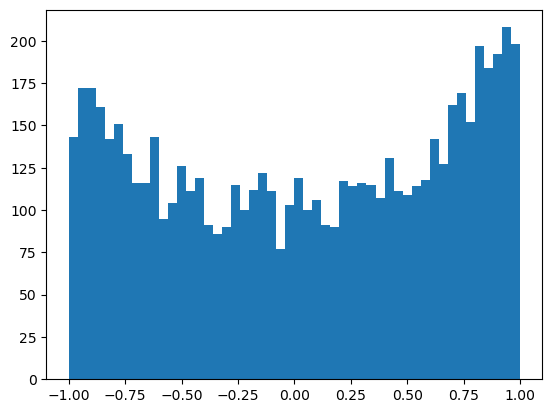

In [54]:
# This shows the tanh values. If it is heavily skewed on the tails, start sweating.

plt.hist(h.view(-1).tolist(), 50);

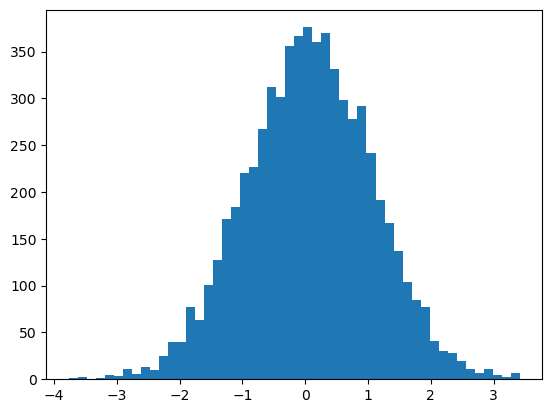

In [55]:
# This is the hidden layer before its fed into the activation function tanh.

plt.hist(hpreact.view(-1).tolist(), 50);

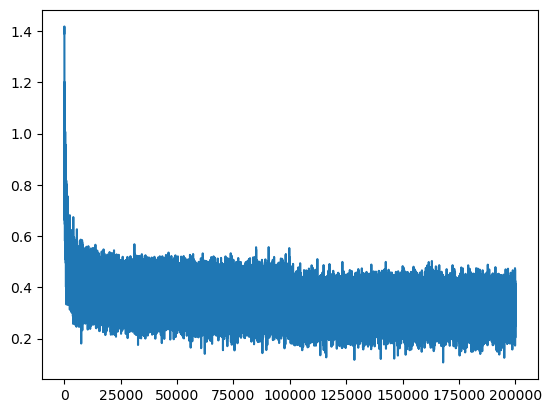

In [33]:
plt.plot(lossi)

In [64]:
# Ok great, we added batch normalization, but now our neural net expects to be fed batches, not single inputs, because we need a mean and std dev. To get around this, we can 'calibrate'
# the statistics. At the end of training, we can get the mean and std dev over the enitre training set and set them as fixed values. Then, when we input a value, we don't need to estimate
# from a batch, but use these calibrated values instead.

# One optimization for this is by calculating during training, instead of doing it after in a 2nd stage. Just keep a running value of the mean and std during training that updates on the side.

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean / std dev over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)


In [67]:
@torch.no_grad() # this decorator disables gradient tracking. This tells Pytorch "Im not going to call for the gradient data, so don't bother tracking it"
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104926586151123


In [60]:
# sample the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        #forward pass
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1) # note the correct broadcasting with adding b1
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        #shift the context window and track samples
        context = context[1:] + [ix]
        out.append(ix)

        #if we sample the '.' character, this is the end, so break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) #decode and print the generated word

mora.
mayah.
see.
mad.
ryll.
renvestendraegusteredielin.
shi.
jen.
edeiseananar.
kayzion.
kamin.
shubergian.
jest.
jair.
jennex.
teron.
ububynder.
yarue.
els.
kayshaykella.
